# 0.Importing Pytorch and setting up device-agnostic code
> Let's get Pytorch loaded and then follow best practice to setup our code to be device-agnostic.

In [ ]:
import torch
from torch import nn

from torch.utils.data import DataLoader
from torchvision import datasets, transforms

# Note: this notebook requires torch >= 1.10.0
torch.__version__

'1.13.1+cu116'

In [ ]:
# Setup device-agnostic code
device = "cuda" if torch.cuda.is_available() else "cpu"
device

'cpu'

In [ ]:
!pip install torchinfo

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [ ]:
import torchinfo

# 1.Get data
> We're going to be using our own custom dataset of pizza, steak and sushi images.

In [ ]:
import requests
import zipfile
from pathlib import Path

# Setup path to data folder
data_path = Path("data/")
image_path = data_path / "pizza_steak_sushi" # data/pizza_steak_sushi

# If the image folder doesn't exist, download it and prepare it... 
if image_path.is_dir():
    print(f"{image_path} directory exists.")
else:
    print(f"Did not find {image_path} directory, creating one...")
    image_path.mkdir(parents=True, exist_ok=True)
    
    # Download pizza, steak, sushi data
    with open(data_path / "pizza_steak_sushi.zip", "wb") as f:
        request = requests.get("https://github.com/mrdbourke/pytorch-deep-learning/raw/main/data/pizza_steak_sushi.zip")
        print("Downloading pizza, steak, sushi data...")
        f.write(request.content)

    # Unzip pizza, steak, sushi data
    with zipfile.ZipFile(data_path / "pizza_steak_sushi.zip", "r") as zip_ref:
        print("Unzipping pizza, steak, sushi data...") 
        zip_ref.extractall(image_path)

data/pizza_steak_sushi directory exists.


# 2.Become one with the data (data preparation)
> At the beginning od any new machine learning problem, it's paramount to understand the data your're working with. Here we'll take some steps to figure out what data we have.

In [ ]:
import os

def walk_through_dir(dir_path):
  """
  Walks through dir_path returning its contents.
  Args:
    dir_path (str or pathlib.Path): target directory
  
  Returns:
    A print out of:
      number of subdiretories in dir_path
      number of images (files) in each subdirectory
      name of each subdirectory
  """
  for dirpath, dirnames, filenames in os.walk(dir_path):
    print(f"There are {len(dirnames)} directories and {len(filenames)} images in '{dirpath}'.")

In [ ]:
walk_through_dir(image_path)

There are 2 directories and 0 images in 'data/pizza_steak_sushi'.
There are 3 directories and 0 images in 'data/pizza_steak_sushi/train'.
There are 0 directories and 72 images in 'data/pizza_steak_sushi/train/sushi'.
There are 0 directories and 78 images in 'data/pizza_steak_sushi/train/pizza'.
There are 0 directories and 75 images in 'data/pizza_steak_sushi/train/steak'.
There are 3 directories and 0 images in 'data/pizza_steak_sushi/test'.
There are 0 directories and 31 images in 'data/pizza_steak_sushi/test/sushi'.
There are 0 directories and 25 images in 'data/pizza_steak_sushi/test/pizza'.
There are 0 directories and 19 images in 'data/pizza_steak_sushi/test/steak'.


In [ ]:
# Setup train and testing paths
train_dir = image_path / "train"
test_dir = image_path / "test"

train_dir, test_dir

(PosixPath('data/pizza_steak_sushi/train'),
 PosixPath('data/pizza_steak_sushi/test'))

## Visualize an image

Random image path: data/pizza_steak_sushi/train/sushi/821108.jpg
Image class: sushi
Image height: 383
Image width: 512


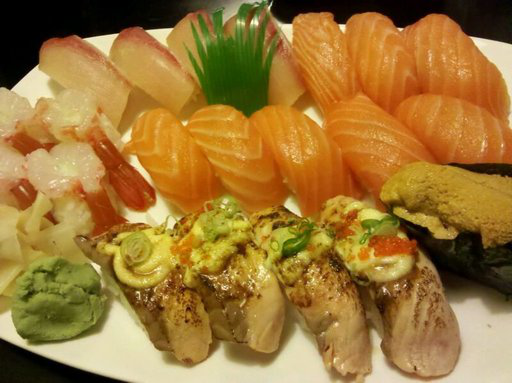

In [ ]:
import random
from PIL import Image

# Set seed
random.seed(42) # <- try changing this and see what happens

# 1. Get all image paths (* means "any combination")
image_path_list = list(image_path.glob("*/*/*.jpg"))

# 2. Get random image path
random_image_path = random.choice(image_path_list)

# 3. Get image class from path name (the image class is the name of the directory where the image is stored)
image_class = random_image_path.parent.stem

# 4. Open image
img = Image.open(random_image_path)

# 5. Print metadata
print(f"Random image path: {random_image_path}")
print(f"Image class: {image_class}")
print(f"Image height: {img.height}") 
print(f"Image width: {img.width}")
img

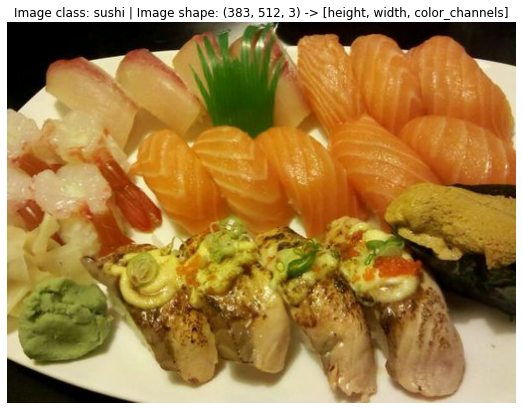

In [ ]:
import numpy as np
import matplotlib.pyplot as plt

# Turn the image into an array
img_as_array = np.asarray(img)

# Plot the image with matplotlib
plt.figure(figsize=(10, 7))
plt.imshow(img_as_array)
plt.title(f"Image class: {image_class} | Image shape: {img_as_array.shape} -> [height, width, color_channels]")
plt.axis(False);

# 3.Model 0: TinyVGG without data augmentation
> By this stage, we'll have our data ready, let's build a model capable of fitting it. We'll also create some training and testing functions for training and evaluating our model.

## What is VGG16?
- 옥스포트 대학의 연구팀 VGG에 의해 개발된 모델로써, 2014년 이미지넷 이미지 인식 대회에서 준우승을 한 모델이다.    
- 1등을 한 GoogleNet보다 단순하면서 성능은 거의 차이가 나지 않은 VGG가 주목을 많이 받았습니다.
  - VGG network 구성: 16 layers(convolution + fully nected)로 구성되어 있다.  

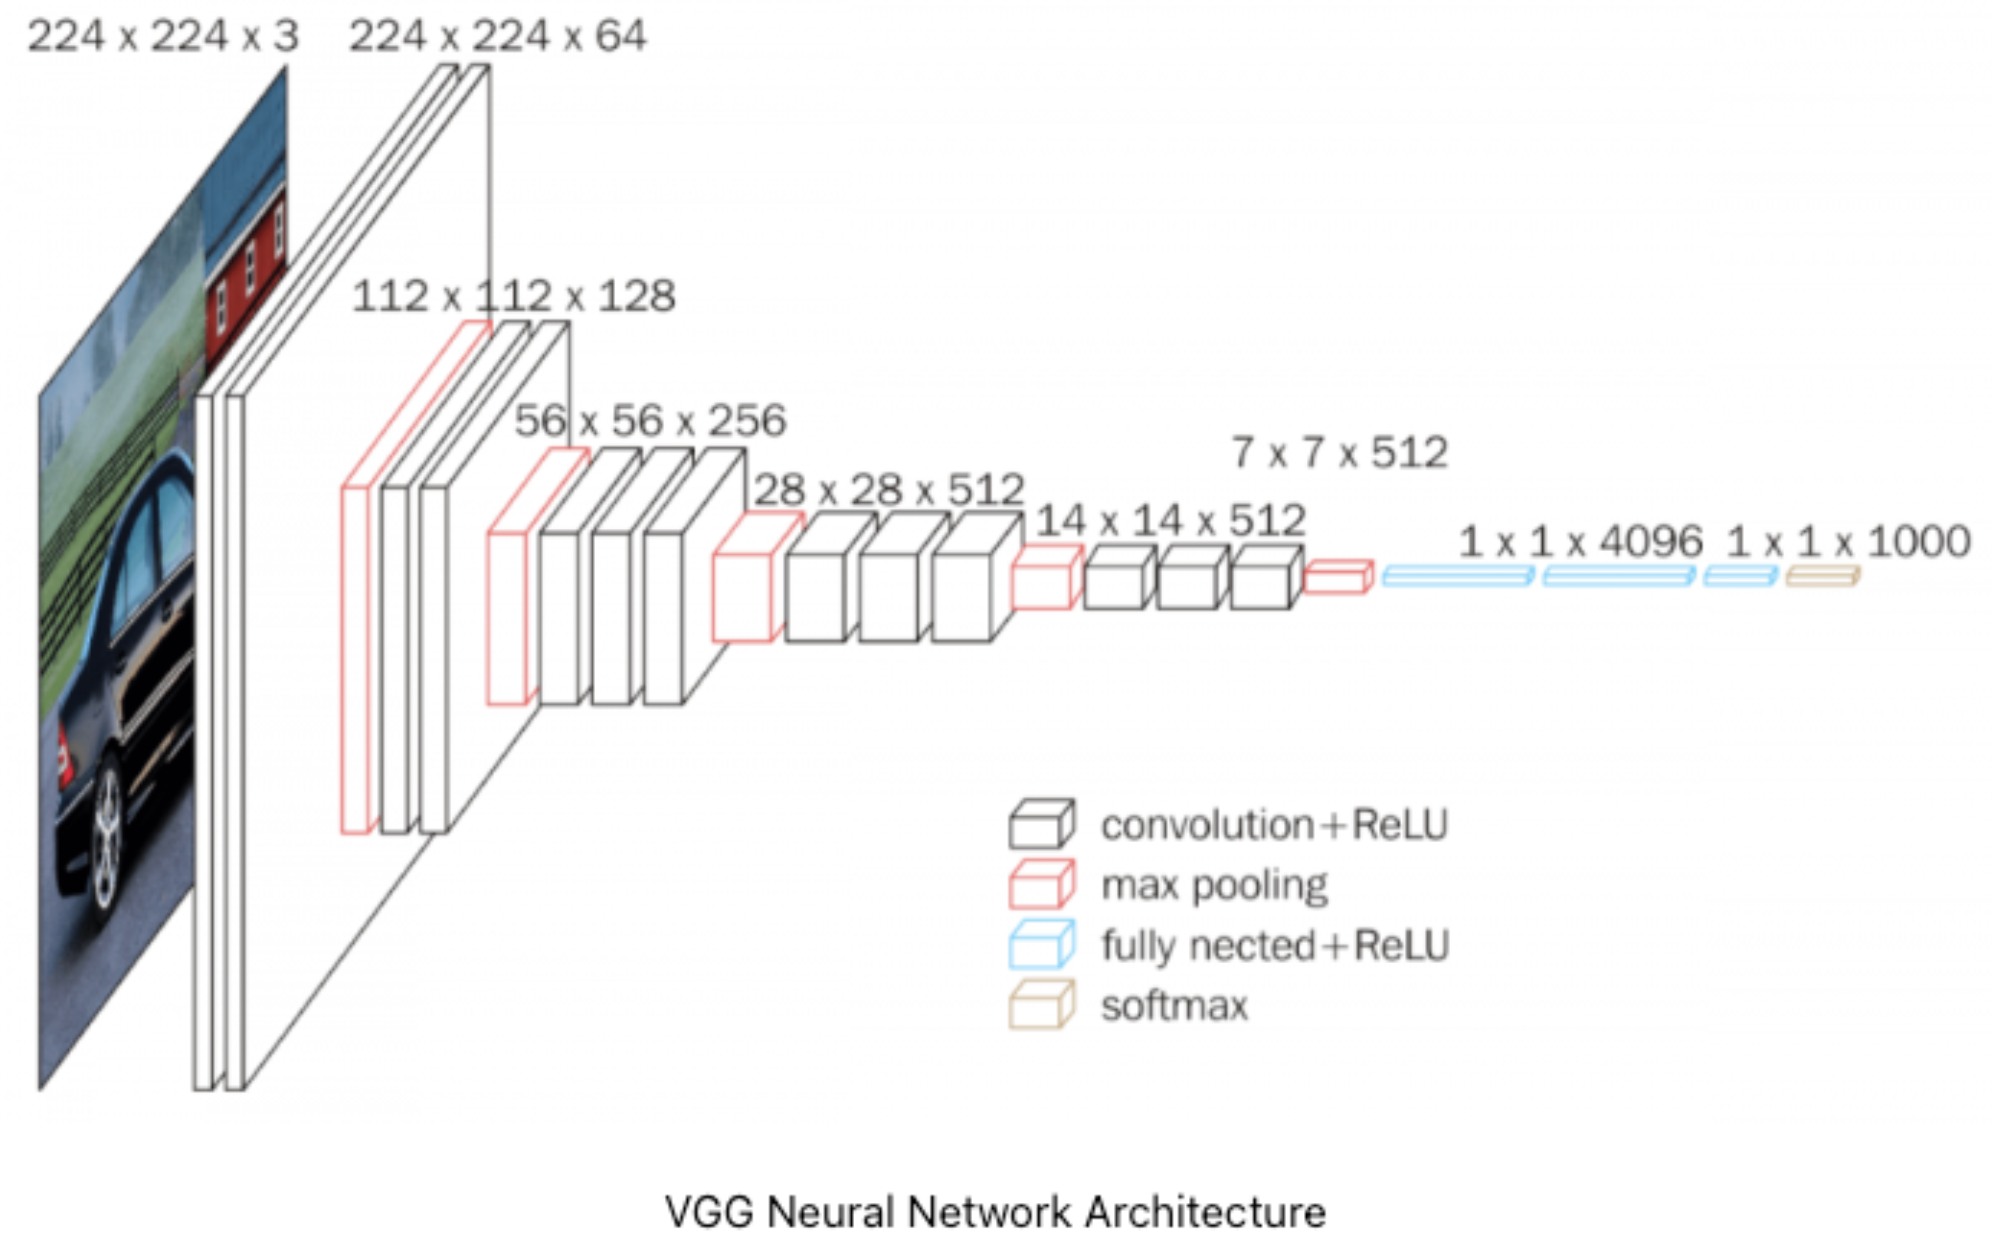

## Creating transforms and loading data

In [ ]:
# Create simple transform
simple_transform = transforms.Compose([ 
    transforms.Resize((64, 64)),
    transforms.ToTensor(),
])

In [ ]:
# 1. Load and transform data
from torchvision import datasets

train_data = datasets.ImageFolder(root=train_dir, transform=simple_transform)
test_data = datasets.ImageFolder(root=test_dir, transform=simple_transform)

In [ ]:
# 2. Turn data into DataLoaders
import os
from torch.utils.data import DataLoader

# Setup batch size and number of workers 
BATCH_SIZE = 32
NUM_WORKERS = os.cpu_count()
print(f"Creating DataLoader's with batch size {BATCH_SIZE} and {NUM_WORKERS} workers.")

# Create DataLoader's
train_dataloader = DataLoader(train_data, 
                                     batch_size=BATCH_SIZE, 
                                     shuffle=True, 
                                     num_workers=NUM_WORKERS)

test_dataloader = DataLoader(test_data, 
                                    batch_size=BATCH_SIZE, 
                                    shuffle=False, 
                                    num_workers=NUM_WORKERS)

train_dataloader, test_dataloader

Creating DataLoader's with batch size 32 and 2 workers.


(<torch.utils.data.dataloader.DataLoader at 0x7ff79daf6ee0>,
 <torch.utils.data.dataloader.DataLoader at 0x7ff837bc1850>)

## Create TinyVGG model class

In [ ]:
class TinyVGG(nn.Module):
    """
    Model architecture copying TinyVGG from: 
    https://poloclub.github.io/cnn-explainer/
    """
    def __init__(self, input_shape: int, hidden_units: int, output_shape: int) -> None:
        super().__init__()
        self.conv_block_1 = nn.Sequential(
            nn.Conv2d(in_channels=input_shape, 
                      out_channels=hidden_units, 
                      kernel_size=3, # how big is the square that's going over the image?
                      stride=1, # default
                      padding=1), # options = "valid" (no padding) or "same" (output has same shape as input) or int for specific number 
            nn.ReLU(),
            nn.Conv2d(in_channels=hidden_units, 
                      out_channels=hidden_units,
                      kernel_size=3,
                      stride=1,
                      padding=1),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2,
                         stride=2) # default stride value is same as kernel_size
        )
        self.conv_block_2 = nn.Sequential(
            nn.Conv2d(hidden_units, hidden_units, kernel_size=3, padding=1),
            nn.ReLU(),
            nn.Conv2d(hidden_units, hidden_units, kernel_size=3, padding=1),
            nn.ReLU(),
            nn.MaxPool2d(2)
        )
        self.classifier = nn.Sequential(
            nn.Flatten(),
            # Where did this in_features shape come from? 
            # It's because each layer of our network compresses and changes the shape of our inputs data.
            nn.Linear(in_features=hidden_units*16*16,
                      out_features=output_shape)
        )
    
    def forward(self, x: torch.Tensor):
        x = self.conv_block_1(x)
        # print(x.shape)
        x = self.conv_block_2(x)
        # print(x.shape)
        x = self.classifier(x)
        # print(x.shape)
        return x
        # return self.classifier(self.conv_block_2(self.conv_block_1(x))) # <- leverage the benefits of operator fusion

In [ ]:
torch.manual_seed(42)
model_0 = TinyVGG(input_shape=3, # number of color channels (3 for RGB) 
                  hidden_units=10, 
                  output_shape=len(train_data.classes)).to(device)
model_0

TinyVGG(
  (conv_block_1): Sequential(
    (0): Conv2d(3, 10, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU()
    (2): Conv2d(10, 10, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (3): ReLU()
    (4): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (conv_block_2): Sequential(
    (0): Conv2d(10, 10, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU()
    (2): Conv2d(10, 10, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (3): ReLU()
    (4): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (classifier): Sequential(
    (0): Flatten(start_dim=1, end_dim=-1)
    (1): Linear(in_features=2560, out_features=3, bias=True)
  )
)

In [ ]:
torchinfo.summary(model_0,(32, 3, 64, 64))

Layer (type:depth-idx)                   Output Shape              Param #
TinyVGG                                  [32, 3]                   --
├─Sequential: 1-1                        [32, 10, 32, 32]          --
│    └─Conv2d: 2-1                       [32, 10, 64, 64]          280
│    └─ReLU: 2-2                         [32, 10, 64, 64]          --
│    └─Conv2d: 2-3                       [32, 10, 64, 64]          910
│    └─ReLU: 2-4                         [32, 10, 64, 64]          --
│    └─MaxPool2d: 2-5                    [32, 10, 32, 32]          --
├─Sequential: 1-2                        [32, 10, 16, 16]          --
│    └─Conv2d: 2-6                       [32, 10, 32, 32]          910
│    └─ReLU: 2-7                         [32, 10, 32, 32]          --
│    └─Conv2d: 2-8                       [32, 10, 32, 32]          910
│    └─ReLU: 2-9                         [32, 10, 32, 32]          --
│    └─MaxPool2d: 2-10                   [32, 10, 16, 16]          --
├─Sequentia

## Try a forward pass on a single image (to test the model)

In [ ]:
# 1. Get a batch of images and labels from the DataLoader
img_batch, label_batch = next(iter(train_dataloader))

# 2. Get a single image from the batch and unsqueeze the image so its shape fits the model
img_single, label_single = img_batch[0].unsqueeze(dim=0), label_batch[0]
print(f"Single image shape: {img_single.shape}\n")

# 3. Perform a forward pass on a single image
model_0.eval()
with torch.inference_mode():
    pred = model_0(img_single.to(device))
    
# 4. Print out what's happening and convert model logits -> pred probs -> pred label
print(f"Output logits:\n{pred}\n")
print(f"Output prediction probabilities:\n{torch.softmax(pred, dim=1)}\n")
print(f"Output prediction label:\n{torch.argmax(torch.softmax(pred, dim=1), dim=1)}\n")
print(f"Actual label:\n{label_single}")

Single image shape: torch.Size([1, 3, 64, 64])

Output logits:
tensor([[0.0601, 0.0587, 0.0402]])

Output prediction probabilities:
tensor([[0.3357, 0.3352, 0.3291]])

Output prediction label:
tensor([0])

Actual label:
0


## Create train & test loop functions

Specifically, we're going to make three functions:
1. `train_step()`: takes in a model, a `DataLoader`, a loss function and an optimizer and trains the model on the `DataLoader`.
2. `test_step()`: takes in a model, a `DataLoader` and a loss function and evaluates the model on the `DataLaoder`.
3. `train()`: performs 1. and 2. together for a given number of epochs and returns a results dictionary.

In [ ]:
def train_step(model: torch.nn.Module, 
               dataloader: torch.utils.data.DataLoader, 
               loss_fn: torch.nn.Module, 
               optimizer: torch.optim.Optimizer):
    # Put model in train mode
    model.train()
    
    # Setup train loss and train accuracy values
    train_loss, train_acc = 0, 0
    
    # Loop through data loader data batches
    for batch, (X, y) in enumerate(dataloader):
        # Send data to target device
        X, y = X.to(device), y.to(device)

        # 1. Forward pass
        y_pred = model(X)

        # 2. Calculate  and accumulate loss
        loss = loss_fn(y_pred, y)
        train_loss += loss.item() 

        # 3. Optimizer zero grad
        optimizer.zero_grad()

        # 4. Loss backward
        loss.backward()

        # 5. Optimizer step
        optimizer.step()

        # Calculate and accumulate accuracy metric across all batches
        y_pred_class = torch.argmax(torch.softmax(y_pred, dim=1), dim=1)
        train_acc += (y_pred_class == y).sum().item()/len(y_pred)

    # Adjust metrics to get average loss and accuracy per batch 
    train_loss = train_loss / len(dataloader)
    train_acc = train_acc / len(dataloader)
    return train_loss, train_acc

In [ ]:
def test_step(model: torch.nn.Module, 
              dataloader: torch.utils.data.DataLoader, 
              loss_fn: torch.nn.Module):
    # Put model in eval mode
    model.eval() 
    
    # Setup test loss and test accuracy values
    test_loss, test_acc = 0, 0
    
    # Turn on inference context manager
    with torch.inference_mode():
        # Loop through DataLoader batches
        for batch, (X, y) in enumerate(dataloader):
            # Send data to target device
            X, y = X.to(device), y.to(device)
    
            # 1. Forward pass
            test_pred_logits = model(X)

            # 2. Calculate and accumulate loss
            loss = loss_fn(test_pred_logits, y)
            test_loss += loss.item()
            
            # Calculate and accumulate accuracy
            test_pred_labels = test_pred_logits.argmax(dim=1)
            test_acc += ((test_pred_labels == y).sum().item()/len(test_pred_labels))
            
    # Adjust metrics to get average loss and accuracy per batch 
    test_loss = test_loss / len(dataloader)
    test_acc = test_acc / len(dataloader)
    return test_loss, test_acc

## Creating a `train()` function to combine `train_step()` and `test_step()`

In [ ]:
from tqdm.auto import tqdm

# 1. Take in various parameters required for training and test steps
def train(model: torch.nn.Module, 
          train_dataloader: torch.utils.data.DataLoader, 
          test_dataloader: torch.utils.data.DataLoader, 
          optimizer: torch.optim.Optimizer,
          loss_fn: torch.nn.Module = nn.CrossEntropyLoss(),
          epochs: int = 5):
    
    # 2. Create empty results dictionary
    results = {"train_loss": [],
        "train_acc": [],
        "test_loss": [],
        "test_acc": []
    }
    
    # 3. Loop through training and testing steps for a number of epochs
    for epoch in tqdm(range(epochs)):
        train_loss, train_acc = train_step(model=model,
                                           dataloader=train_dataloader,
                                           loss_fn=loss_fn,
                                           optimizer=optimizer)
        test_loss, test_acc = test_step(model=model,
            dataloader=test_dataloader,
            loss_fn=loss_fn)
        
        # 4. Print out what's happening
        print(
            f"Epoch: {epoch+1} | "
            f"train_loss: {train_loss:.4f} | "
            f"train_acc: {train_acc:.4f} | "
            f"test_loss: {test_loss:.4f} | "
            f"test_acc: {test_acc:.4f}"
        )

        # 5. Update results dictionary
        results["train_loss"].append(train_loss)
        results["train_acc"].append(train_acc)
        results["test_loss"].append(test_loss)
        results["test_acc"].append(test_acc)

    # 6. Return the filled results at the end of the epochs
    return results

## Train and Evaluate Model 0

In [ ]:
# Set random seeds
torch.manual_seed(42) 
torch.cuda.manual_seed(42)

# Set number of epochs
NUM_EPOCHS = 5

# Recreate an instance of TinyVGG
model_0 = TinyVGG(input_shape=3, # number of color channels (3 for RGB) 
                  hidden_units=10, 
                  output_shape=len(train_data.classes)).to(device)

# Setup loss function and optimizer
loss_fn = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(params=model_0.parameters(), lr=0.001)

# Start the timer
from timeit import default_timer as timer 
start_time = timer()

# Train model_0 
model_0_results = train(model=model_0, 
                        train_dataloader=train_dataloader,
                        test_dataloader=test_dataloader,
                        optimizer=optimizer,
                        loss_fn=loss_fn, 
                        epochs=NUM_EPOCHS)

# End the timer and print out how long it took
end_time = timer()
print(f"Total training time: {end_time-start_time:.3f} seconds")

  0%|          | 0/5 [00:00<?, ?it/s]

Epoch: 1 | train_loss: 1.1078 | train_acc: 0.2578 | test_loss: 1.1360 | test_acc: 0.2604
Epoch: 2 | train_loss: 1.0847 | train_acc: 0.4258 | test_loss: 1.1620 | test_acc: 0.1979
Epoch: 3 | train_loss: 1.1157 | train_acc: 0.2930 | test_loss: 1.1695 | test_acc: 0.1979
Epoch: 4 | train_loss: 1.0955 | train_acc: 0.4141 | test_loss: 1.1386 | test_acc: 0.1979
Epoch: 5 | train_loss: 1.0981 | train_acc: 0.2930 | test_loss: 1.1435 | test_acc: 0.1979
Total training time: 22.362 seconds


## Plot the loss curves of Model 0

In [ ]:
# Check the model_0_results keys
model_0_results.keys()

dict_keys(['train_loss', 'train_acc', 'test_loss', 'test_acc'])

In [ ]:
def plot_loss_curves(results):
    """Plots training curves of a results dictionary.

    Args:
        results (dict): dictionary containing list of values, e.g.
            {"train_loss": [...],
             "train_acc": [...],
             "test_loss": [...],
             "test_acc": [...]}
    """
    
    # Get the loss values of the results dictionary (training and test)
    loss = results['train_loss']
    test_loss = results['test_loss']

    # Get the accuracy values of the results dictionary (training and test)
    accuracy = results['train_acc']
    test_accuracy = results['test_acc']

    # Figure out how many epochs there were
    epochs = range(len(results['train_loss']))

    # Setup a plot 
    plt.figure(figsize=(15, 7))

    # Plot loss
    plt.subplot(1, 2, 1)
    plt.plot(epochs, loss, label='train_loss')
    plt.plot(epochs, test_loss, label='test_loss')
    plt.title('Loss')
    plt.xlabel('Epochs')
    plt.legend()

    # Plot accuracy
    plt.subplot(1, 2, 2)
    plt.plot(epochs, accuracy, label='train_accuracy')
    plt.plot(epochs, test_accuracy, label='test_accuracy')
    plt.title('Accuracy')
    plt.xlabel('Epochs')
    plt.legend();

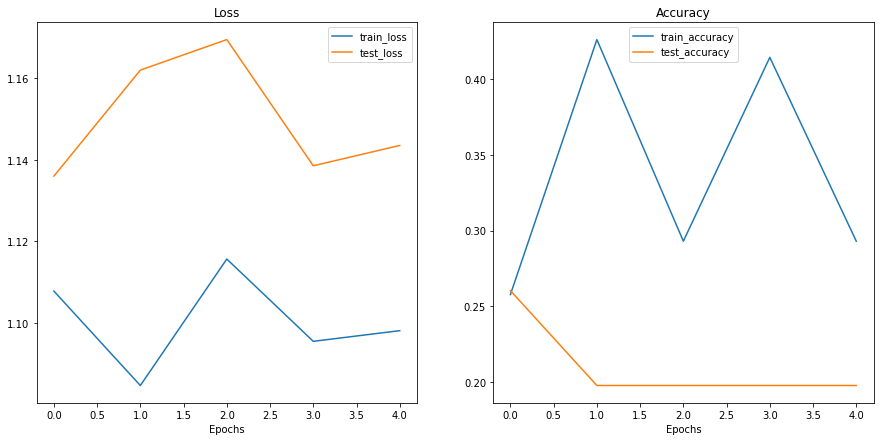

In [ ]:
plot_loss_curves(model_0_results)

# 4.Exploring loss curves
> Loss curves are a great way to see how your model is training/improving over time. Tehy're also a good way to see if your model is underfitting or overfitting.

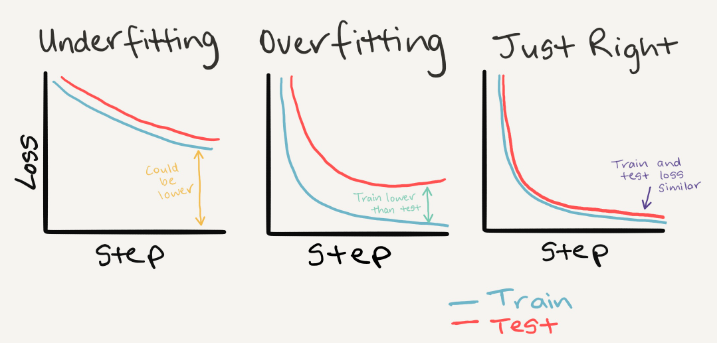

## How to deal with overfitting
A common technique of preventing overfitting is known as [regularization.](https://ml-cheatsheet.readthedocs.io/en/latest/regularization.html)   

Let's discuss a few methods to prevnet overfitting.
- Get more data
- Simplify your model
- Use [data augmentation](https://developers.google.com/machine-learning/glossary?hl=ko#data-augmentation)
- Use [transfer learning](https://developers.google.com/machine-learning/glossary?hl=ko#transfer-learning)
- Use dropout layers
- Use learning rate decay
- Use [early stopping](https://developers.google.com/machine-learning/glossary?hl=ko#early_stopping)





# 5.Model 1: TinyVGG with data augmentation
> By now, we've tried a model without, how about we try one with data augmentation?

## Create transform with data augmentation

In [ ]:
# Create training transform with TrivialAugment
train_transform_trivial_augment = transforms.Compose([
    transforms.Resize((64, 64)),
    transforms.TrivialAugmentWide(num_magnitude_bins=31),
    transforms.ToTensor() 
])

# Create testing transform (no data augmentation)
test_transform = transforms.Compose([
    transforms.Resize((64, 64)),
    transforms.ToTensor()
])

## Create train and test `Dataset`'s and `DataLoader`'s

In [ ]:
# Turn image folders into Datasets
train_data_augmented = datasets.ImageFolder(train_dir, transform=train_transform_trivial_augment)
test_data_simple = datasets.ImageFolder(test_dir, transform=test_transform)

train_data_augmented, test_data_simple

(Dataset ImageFolder
     Number of datapoints: 225
     Root location: data/pizza_steak_sushi/train
     StandardTransform
 Transform: Compose(
                Resize(size=(64, 64), interpolation=bilinear, max_size=None, antialias=None)
                TrivialAugmentWide(num_magnitude_bins=31, interpolation=InterpolationMode.NEAREST, fill=None)
                ToTensor()
            ), Dataset ImageFolder
     Number of datapoints: 75
     Root location: data/pizza_steak_sushi/test
     StandardTransform
 Transform: Compose(
                Resize(size=(64, 64), interpolation=bilinear, max_size=None, antialias=None)
                ToTensor()
            ))

In [ ]:
# Turn Datasets into DataLoader's
import os

BATCH_SIZE = 32
NUM_WORKERS = os.cpu_count()

torch.manual_seed(42)
train_dataloader_augmented = DataLoader(train_data_augmented, 
                                        batch_size=BATCH_SIZE, 
                                        shuffle=True,
                                        num_workers=NUM_WORKERS)

test_dataloader = DataLoader(test_data_simple, 
                                    batch_size=BATCH_SIZE, 
                                    shuffle=False, 
                                    num_workers=NUM_WORKERS)

train_dataloader_augmented, test_dataloader

(<torch.utils.data.dataloader.DataLoader at 0x7ff798432940>,
 <torch.utils.data.dataloader.DataLoader at 0x7ff837bc1850>)

## Construct and train Model 1

In [ ]:
# Create model_1 and send it to the target device
torch.manual_seed(42)
model_1 = TinyVGG(
    input_shape=3,
    hidden_units=10,
    output_shape=len(train_data_augmented.classes)).to(device)

model_1

TinyVGG(
  (conv_block_1): Sequential(
    (0): Conv2d(3, 10, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU()
    (2): Conv2d(10, 10, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (3): ReLU()
    (4): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (conv_block_2): Sequential(
    (0): Conv2d(10, 10, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU()
    (2): Conv2d(10, 10, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (3): ReLU()
    (4): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (classifier): Sequential(
    (0): Flatten(start_dim=1, end_dim=-1)
    (1): Linear(in_features=2560, out_features=3, bias=True)
  )
)

In [ ]:
torchinfo.summary(model_1,(32, 3, 64, 64))

Layer (type:depth-idx)                   Output Shape              Param #
TinyVGG                                  [32, 3]                   --
├─Sequential: 1-1                        [32, 10, 32, 32]          --
│    └─Conv2d: 2-1                       [32, 10, 64, 64]          280
│    └─ReLU: 2-2                         [32, 10, 64, 64]          --
│    └─Conv2d: 2-3                       [32, 10, 64, 64]          910
│    └─ReLU: 2-4                         [32, 10, 64, 64]          --
│    └─MaxPool2d: 2-5                    [32, 10, 32, 32]          --
├─Sequential: 1-2                        [32, 10, 16, 16]          --
│    └─Conv2d: 2-6                       [32, 10, 32, 32]          910
│    └─ReLU: 2-7                         [32, 10, 32, 32]          --
│    └─Conv2d: 2-8                       [32, 10, 32, 32]          910
│    └─ReLU: 2-9                         [32, 10, 32, 32]          --
│    └─MaxPool2d: 2-10                   [32, 10, 16, 16]          --
├─Sequentia

In [ ]:
# Set random seeds
torch.manual_seed(42) 
torch.cuda.manual_seed(42)

# Set number of epochs
NUM_EPOCHS = 5

# Setup loss function and optimizer
loss_fn = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(params=model_1.parameters(), lr=0.001)

# Start the timer
from timeit import default_timer as timer 
start_time = timer()

# Train model_1
model_1_results = train(model=model_1, 
                        train_dataloader=train_dataloader_augmented,
                        test_dataloader=test_dataloader_simple,
                        optimizer=optimizer,
                        loss_fn=loss_fn, 
                        epochs=NUM_EPOCHS)

# End the timer and print out how long it took
end_time = timer()
print(f"Total training time: {end_time-start_time:.3f} seconds")

  0%|          | 0/5 [00:00<?, ?it/s]

Epoch: 1 | train_loss: 1.1076 | train_acc: 0.2500 | test_loss: 1.1060 | test_acc: 0.2604
Epoch: 2 | train_loss: 1.0792 | train_acc: 0.4258 | test_loss: 1.1384 | test_acc: 0.2604
Epoch: 3 | train_loss: 1.0810 | train_acc: 0.4258 | test_loss: 1.1691 | test_acc: 0.2604
Epoch: 4 | train_loss: 1.1291 | train_acc: 0.3047 | test_loss: 1.1624 | test_acc: 0.2604
Epoch: 5 | train_loss: 1.0901 | train_acc: 0.4258 | test_loss: 1.1478 | test_acc: 0.2604
Total training time: 14.836 seconds


## Plot the loss curves of Model 1

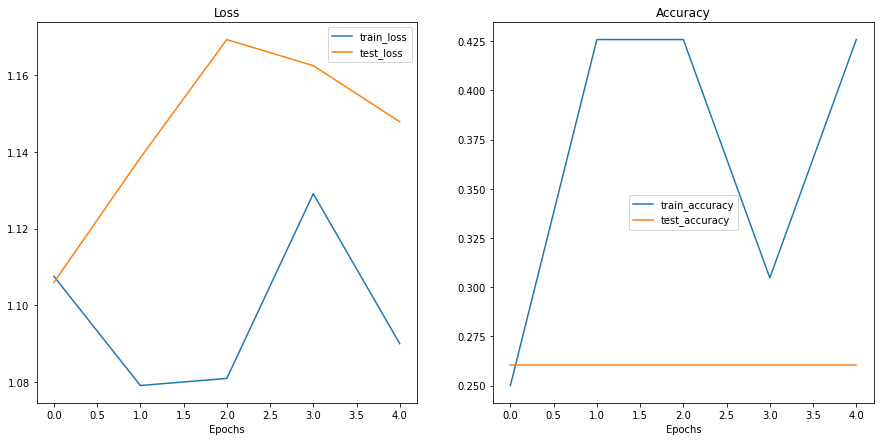

In [ ]:
plot_loss_curves(model_1_results)

# 6.Compare model results
> Let's compare our different models'loss cuves and see which performed better and discuss some options for improving performance.

In [ ]:
import pandas as pd

model_0_df = pd.DataFrame(model_0_results)
model_1_df = pd.DataFrame(model_1_results)
model_0_df

,train_loss,train_acc,test_loss,test_acc
0,1.107830,0.257812,1.136019,0.260417
1,1.084671,0.425781,1.162027,0.197917
2,1.115688,0.292969,1.169516,0.197917
3,1.095505,0.414062,1.138561,0.197917
4,1.098120,0.292969,1.143542,0.197917


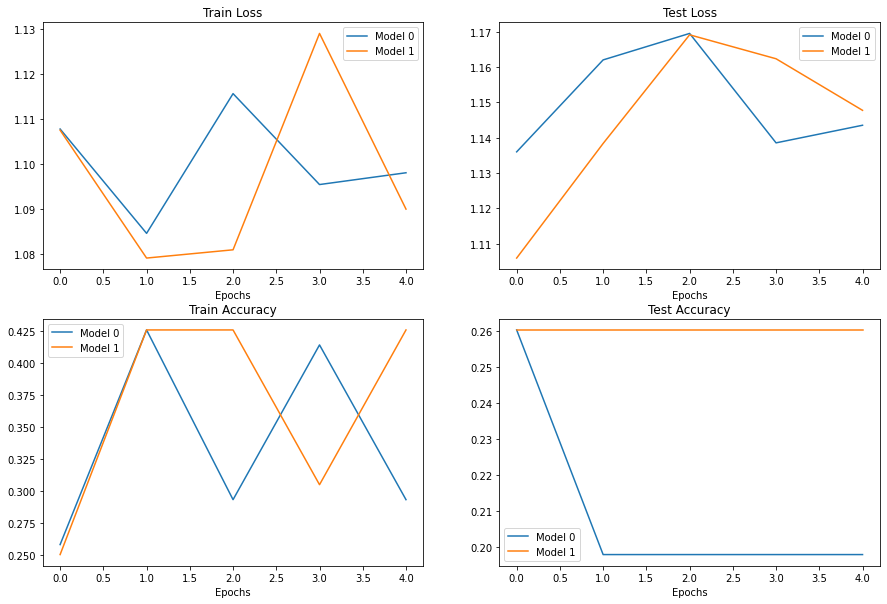

In [ ]:
# Setup a plot 
plt.figure(figsize=(15, 10))

# Get number of epochs
epochs = range(len(model_0_df))

# Plot train loss
plt.subplot(2, 2, 1)
plt.plot(epochs, model_0_df["train_loss"], label="Model 0")
plt.plot(epochs, model_1_df["train_loss"], label="Model 1")
plt.title("Train Loss")
plt.xlabel("Epochs")
plt.legend()

# Plot test loss
plt.subplot(2, 2, 2)
plt.plot(epochs, model_0_df["test_loss"], label="Model 0")
plt.plot(epochs, model_1_df["test_loss"], label="Model 1")
plt.title("Test Loss")
plt.xlabel("Epochs")
plt.legend()

# Plot train accuracy
plt.subplot(2, 2, 3)
plt.plot(epochs, model_0_df["train_acc"], label="Model 0")
plt.plot(epochs, model_1_df["train_acc"], label="Model 1")
plt.title("Train Accuracy")
plt.xlabel("Epochs")
plt.legend()

# Plot test accuracy
plt.subplot(2, 2, 4)
plt.plot(epochs, model_0_df["test_acc"], label="Model 0")
plt.plot(epochs, model_1_df["test_acc"], label="Model 1")
plt.title("Test Accuracy")
plt.xlabel("Epochs")
plt.legend();

# 7.Making a prediction on a custom image
> Our model is trained to on a dataset of pizza, steak and sushi images. In this section we'll cover how to use our trained model to predict on an image outside of our existing dataset.

## Loading in a custom image with Pytorch

In [ ]:
# Download custom image
import requests

# Setup custom image path
custom_image_path = data_path / "04-pizza-dad.jpeg"

# Download the image if it doesn't already exist
if not custom_image_path.is_file():
    with open(custom_image_path, "wb") as f:
        # When downloading from GitHub, need to use the "raw" file link
        request = requests.get("https://raw.githubusercontent.com/mrdbourke/pytorch-deep-learning/main/images/04-pizza-dad.jpeg")
        print(f"Downloading {custom_image_path}...")
        f.write(request.content)
else:
    print(f"{custom_image_path} already exists, skipping download.")

In [ ]:
import torchvision

# Load in custom image and convert the tensor values to float32
custom_image = torchvision.io.read_image(str(custom_image_path)).type(torch.float32)

# Divide the image pixel values by 255 to get them between [0, 1]
custom_image = custom_image / 255. 

# Print out image data
# print(f"Custom image tensor:\n{custom_image}\n")
print(f"Custom image shape: {custom_image.shape}\n")
print(f"Custom image dtype: {custom_image.dtype}")

Custom image shape: torch.Size([3, 4032, 3024])

Custom image dtype: torch.float32


## Predicting on custom images with a trained Pytorch model

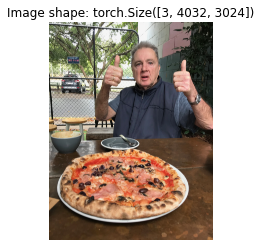

In [ ]:
# Plot custom image
plt.imshow(custom_image.permute(1, 2, 0)) # need to permute image dimensions from CHW -> HWC otherwise matplotlib will error
plt.title(f"Image shape: {custom_image.shape}")
plt.axis(False);

In [ ]:
# Create transform pipleine to resize image
custom_image_transform = transforms.Compose([
    transforms.Resize((64, 64)),
])

# Transform target image
custom_image_transformed = custom_image_transform(custom_image)

# Print out original shape and new shape
print(f"Original shape: {custom_image.shape}")
print(f"New shape: {custom_image_transformed.shape}")

Original shape: torch.Size([3, 4032, 3024])
New shape: torch.Size([3, 64, 64])


In [ ]:
model_1.eval()

with torch.inference_mode():
    # Add an extra dimension to image
    custom_image_transformed_with_batch_size = custom_image_transformed.unsqueeze(dim=0)
    
    # Print out different shapes
    print(f"Custom image transformed shape: {custom_image_transformed.shape}")
    print(f"Unsqueezed custom image shape: {custom_image_transformed_with_batch_size.shape}")
    
    # Make a prediction on image with an extra dimension
    custom_image_pred = model_1(custom_image_transformed.unsqueeze(dim=0).to(device))

Custom image transformed shape: torch.Size([3, 64, 64])
Unsqueezed custom image shape: torch.Size([1, 3, 64, 64])


In [ ]:
custom_image_pred

tensor([[ 0.1162,  0.0330, -0.1406]])

In [ ]:
# Print out prediction logits
print(f"Prediction logits: {custom_image_pred}")

# Convert logits -> prediction probabilities (using torch.softmax() for multi-class classification)
custom_image_pred_probs = torch.softmax(custom_image_pred, dim=1)
print(f"Prediction probabilities: {custom_image_pred_probs}")

# Convert prediction probabilities -> prediction labels
custom_image_pred_label = torch.argmax(custom_image_pred_probs, dim=1)
print(f"Prediction label: {custom_image_pred_label}")

Prediction logits: tensor([[ 0.1162,  0.0330, -0.1406]])
Prediction probabilities: tensor([[0.3712, 0.3416, 0.2872]])
Prediction label: tensor([0])


In [ ]:
# Get class names as a list
class_names = train_data.classes
class_names

['pizza', 'steak', 'sushi']

In [ ]:
# Find the predicted label
custom_image_pred_class = class_names[custom_image_pred_label.cpu()] # put pred label to CPU, otherwise will error
custom_image_pred_class

'pizza'

## Putting custom image prediction together

In [ ]:
def pred_and_plot_image(model: torch.nn.Module, 
                        image_path: str, 
                        class_names = None, 
                        transform=None,
                        device: torch.device = device):
    """Makes a prediction on a target image and plots the image with its prediction."""
    
    # 1. Load in image and convert the tensor values to float32
    target_image = torchvision.io.read_image(str(image_path)).type(torch.float32)
    
    # 2. Divide the image pixel values by 255 to get them between [0, 1]
    target_image = target_image / 255. 
    
    # 3. Transform if necessary
    if transform:
        target_image = transform(target_image)
    
    # 4. Make sure the model is on the target device
    model.to(device)
    
    # 5. Turn on model evaluation mode and inference mode
    model.eval()
    with torch.inference_mode():
        # Add an extra dimension to the image
        target_image = target_image.unsqueeze(dim=0)
    
        # Make a prediction on image with an extra dimension and send it to the target device
        target_image_pred = model(target_image.to(device))
        
    # 6. Convert logits -> prediction probabilities (using torch.softmax() for multi-class classification)
    target_image_pred_probs = torch.softmax(target_image_pred, dim=1)

    # 7. Convert prediction probabilities -> prediction labels
    target_image_pred_label = torch.argmax(target_image_pred_probs, dim=1)
    
    # 8. Plot the image alongside the prediction and prediction probability
    plt.imshow(target_image.squeeze().permute(1, 2, 0)) # make sure it's the right size for matplotlib
    if class_names:
        title = f"Pred: {class_names[target_image_pred_label.cpu()]} | Prob: {target_image_pred_probs.max().cpu():.3f}"
    else: 
        title = f"Pred: {target_image_pred_label} | Prob: {target_image_pred_probs.max().cpu():.3f}"
    plt.title(title)
    plt.axis(False);

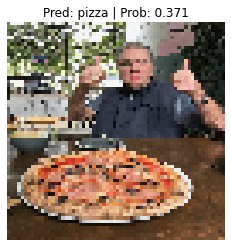

In [ ]:
# Pred on our custom image
pred_and_plot_image(model=model_1,
                    image_path=custom_image_path,
                    class_names=class_names,
                    transform=custom_image_transform,
                    device=device)